In [369]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
import os

csv_file_path = os.path.join(os.getcwd(), 'new_filtered_data.csv')
data = pd.read_csv(csv_file_path).iloc[::-1]

# data = data[data['Exchange Date'] >= '2023-12-12']

data['RSI'] = ta.rsi(data['Close'], length=7)
data['EMAF'] = ta.ema(data['Close'], length=14)

data.dropna(inplace=True)
print(data.head())

    Exchange Date    Close    Net        RSI         EMAF
322    2023-01-26  1093.83  10.70  87.052956  1073.585000
321    2023-01-27  1091.24  -2.59  78.272460  1075.939000
320    2023-01-30  1085.48  -5.76  62.037261  1077.211133
319    2023-01-31  1074.49 -10.99  42.441524  1076.848316
318    2023-02-01  1085.29  10.80  57.744220  1077.973873


## Process data 

In [370]:
data.drop(['Exchange Date'], axis=1, inplace=True)
# data.set_index('Exchange Date', inplace=True)
print(data.head())

       Close    Net        RSI         EMAF
322  1093.83  10.70  87.052956  1073.585000
321  1091.24  -2.59  78.272460  1075.939000
320  1085.48  -5.76  62.037261  1077.211133
319  1074.49 -10.99  42.441524  1076.848316
318  1085.29  10.80  57.744220  1077.973873


## Scale Data

In [371]:
from sklearn.preprocessing import MinMaxScaler

print(data.head(), end='\n\n')
scaler = MinMaxScaler(feature_range=(0,1))
data_set_scaled = scaler.fit_transform(data)

data_set_scaled = np.array(data_set_scaled)
print(data_set_scaled[:20])

       Close    Net        RSI         EMAF
322  1093.83  10.70  87.052956  1073.585000
321  1091.24  -2.59  78.272460  1075.939000
320  1085.48  -5.76  62.037261  1077.211133
319  1074.49 -10.99  42.441524  1076.848316
318  1085.29  10.80  57.744220  1077.973873

[[0.84062865 0.70763698 0.98794689 0.76508609]
 [0.82472834 0.42648614 0.86978627 0.78257325]
 [0.78936706 0.35942458 0.65130643 0.79202355]
 [0.72189821 0.24878358 0.38760327 0.78932828]
 [0.78820063 0.70975249 0.59353426 0.79768972]
 [0.79378722 0.50052888 0.60801725 0.80583764]
 [0.74424458 0.31055638 0.44293484 0.80490589]
 [0.60457978 0.         0.18805249 0.78156465]
 [0.60869298 0.49545166 0.20148207 0.76199921]
 [0.63895881 0.58557224 0.30314783 0.74992562]
 [0.66443612 0.56907129 0.38402091 0.74357239]
 [0.59438885 0.23989846 0.25238102 0.72676473]
 [0.6078949  0.52781891 0.29749547 0.71437718]
 [0.60623734 0.4755659  0.29410419 0.70337387]
 [0.55159924 0.29299767 0.19222685 0.68502227]
 [0.58192645 0.5857838  0.3099

## Separating data in batches

In [372]:
X = []
# how many data points to look behind at before predicting
# 28 because its the average number of days in a month - can be modified
lookback = 28

# go trough every column 

for j in range(len(data_set_scaled[0])):
    X.append([])
    # go trough every data 
    for i in range(lookback, data_set_scaled.shape[0] - 4):
        X[j].append(data_set_scaled[i-lookback:i, j])
        
Y = []
for i in range(lookback, data_set_scaled.shape[0] - 4):
    Y.append(data_set_scaled[i:i+5, 1])

X = np.moveaxis(X, 0, 2)
# Y = np.array(data_set_scaled[lookback:, -1])
Y = np.array(Y)
Y = np.reshape(Y, (len(Y), 5))

# print(X[:5])
# print(Y[:1])

In [373]:
print(X.shape)
print(Y.shape)

(291, 28, 4)
(291, 5)


## Split data into train test sets

In [374]:
split = int(len(X) * 0.8)
X_train , X_test = X[:split], X[split:]
Y_train , Y_test = Y[:split], Y[split:]

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(232, 28, 4)
(59, 28, 4)
(232, 5)
(59, 5)


## LSTM Model

In [375]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
print(tf.config.list_physical_devices('CPU'))
print(keras.__version__)

2.16.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
3.3.3


In [411]:
from keras.src.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

lstm_input = Input(shape=(lookback, len(data_set_scaled[0])), name='lstm_input')
inputs = LSTM(50, name='first_layer', return_sequences=True)(lstm_input)
inputs = LSTM(50, name='second_layer', return_sequences=False)(inputs)
inputs = Dense(25, name='third_layer')(inputs)
inputs = Dense(5, name='dense_layer')(inputs)
output = Activation(keras.activations.tanh, name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=Y_train, batch_size=32, epochs=10, shuffle=True, validation_split=0.1)
# model.fit(x=X, y=Y, batch_size=32, epochs=10, validation_split=0.1)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.1450 - val_loss: 0.0581
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0426 - val_loss: 0.0446
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0382 - val_loss: 0.0365
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0325 - val_loss: 0.0409
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0326 - val_loss: 0.0361
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0302 - val_loss: 0.0352
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0297 - val_loss: 0.0369
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0289 - val_loss: 0.0347
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0273 - val_loss: 0.0342
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0296 - val_loss: 0.0340


## Overall RMSE 

In [412]:
from sklearn.metrics import root_mean_squared_error

prediction_batch = model.predict(X_test)
rmse = root_mean_squared_error(Y_test, prediction_batch)

print(rmse)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
0.1534281815928701


## Last 5 Days Prediction

In [408]:
test = np.array([X[-1]]) 
prediction = model.predict(test)

print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
[[0.46659037 0.48116446 0.53614193 0.51432145 0.49778384]]


In [409]:
# prediction = [[0.98643256, 1., 0.98103014, 0.90066916, 0.82804346]]
scaled_prediction = scaler.inverse_transform([[test[-1][-1][0], prediction[0][0], 0, 0],
                          [0, prediction[0][1], 0, 0],
                          [0, prediction[0][2], 0, 0],
                          [0, prediction[0][3], 0, 0],
                          [0, prediction[0][4], 0, 0]])

last_predicted = scaled_prediction[0][0]
prediction_set = []
for i in range(5):
    prediction_set.append(last_predicted + scaled_prediction[i][1])
    last_predicted = prediction_set[-1]

print(prediction)
print(prediction_set)

[[0.46659037 0.48116446 0.53614193 0.51432145 0.49778384]]
[1091.0857270124554, 1091.0803708198666, 1093.6737999460101, 1095.235774718225, 1096.0160168209673]


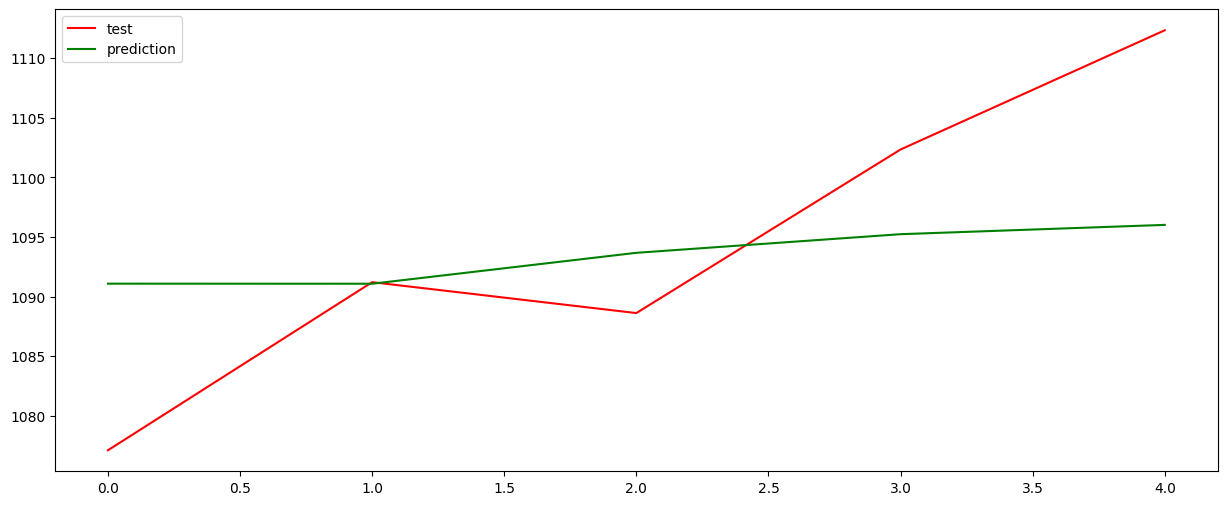

8.517472919881357


In [410]:
plt.figure(figsize=(15,6))
test_set = [1112.34, 1102.34, 1088.62, 1091.21, 1077.11][::-1]

plt.plot(test_set, color='red', label='test')
plt.plot(prediction_set, color='green', label='prediction')
plt.legend()
plt.show()

print(root_mean_squared_error([prediction_set], [test_set]))